## Importation de bibliothèques

In [75]:
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import re
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from string import punctuation
from wordcloud import WordCloud


## Aperçu des informations sur les produits, y compris l'analyse univariée et bivariée

In [3]:
flipkart_df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")
profile = ProfileReport(flipkart_df, html={"style": {"full_width": True}})

profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Suppression de colonnes non pertinentes pour l'étude

In [4]:
flipkart_df = flipkart_df[
    [
        "product_name",
        "product_category_tree",
        "image",
        "description",
        "product_specifications",
    ]
]

display(flipkart_df)


,product_name,product_category_tree,image,description,product_specifications
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,"{""product_specification""=>[{""key""=>""Material"",..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,"{""product_specification""=>[{""key""=>""Number of ..."
1046,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"{""product_specification""=>[{""key""=>""Number of ..."
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"{""product_specification""=>[{""key""=>""Number of ..."
1048,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"{""product_specification""=>[{""key""=>""Number of ..."


## Parsage de l'arborescence des catégories de produits

In [5]:
outside_strip_patrn = re.compile(r'\["(.+?)(\.\.\.)?"\]')


def parse_categ_tree(categ_tree):
    return re.match(outside_strip_patrn, categ_tree).group(1).split(" >> ")


with pd.option_context("mode.chained_assignment", None):
    flipkart_df["product_category_tree"] = flipkart_df["product_category_tree"].apply(
        parse_categ_tree
    )


## Parsage des spécifications des produits

In [6]:
key_val_patrn = re.compile(r'"key"=>"(.+?)", "value"=>"(.+?)"')


def parse_prod_specs(prod_specs):
    specs_dict = {}

    if not pd.isnull(prod_specs):
        for match in re.findall(key_val_patrn, prod_specs):
            specs_dict[match[0]] = match[1]

    return specs_dict


with pd.option_context("mode.chained_assignment", None):
    flipkart_df["product_specifications"] = flipkart_df["product_specifications"].apply(
        parse_prod_specs
    )


## Ajout de colonnes pour chaque niveau de sous-catégories

In [7]:
flipkart_w_subcat_df = flipkart_df.copy()

for i in range(1, len(max(flipkart_w_subcat_df.product_category_tree, key=len)) + 1):
    flipkart_w_subcat_df[f"subcateg_{i}"] = np.nan


def fill_subcategs(row):
    for i in range(0, len(row["product_category_tree"])):
        row[f"subcateg_{i + 1}"] = row["product_category_tree"][i]

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(fill_subcategs, axis=1)

display(flipkart_w_subcat_df)


,product_name,product_category_tree,image,description,product_specifications,subcateg_1,subcateg_2,subcateg_3,subcateg_4,subcateg_5,subcateg_6,subcateg_7
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"{'Brand': 'Elegance', 'Designed For': 'Door', ...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do,NaN,NaN,NaN
1,Sathiyas Cotton Bath Towel,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,"{'Machine Washable': 'Yes', 'Material': 'Cotto...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y",NaN,NaN
2,Eurospa Cotton Terry Face Towel Set,"[Baby Care, Baby Bath & Skin, Baby Bath Towels...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,"{'Material': 'Cotton Terry', 'Design': 'SHUVAM...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE FA,NaN,NaN
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,"{'Brand': 'SANTOSH ROYAL FASHION', 'Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King sized,NaN,NaN
4,Jaipur Print Cotton Floral King sized Double B...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,"{'Machine Washable': 'Yes', 'Brand': 'Jaipur P...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double Bed,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,{'Number of Contents in Sales Package': 'Pack ...,Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,NaN,NaN,NaN
1046,Wallmantra Large Vinyl Sticker Sticker,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,{'Number of Contents in Sales Package': 'Pack ...,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,NaN,NaN,NaN
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,{'Number of Contents in Sales Package': 'Pack ...,Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,NaN,NaN,NaN
1048,Wallmantra Medium Vinyl Sticker Sticker,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,{'Number of Contents in Sales Package': 'Pack ...,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,NaN,NaN,NaN


## Dénombrement des sous-catégories secondaires

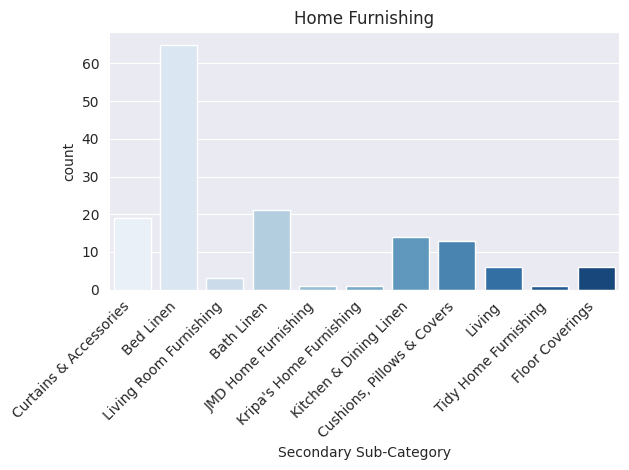

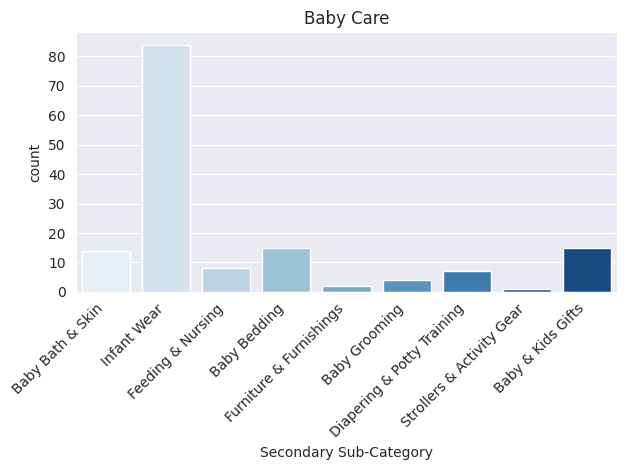

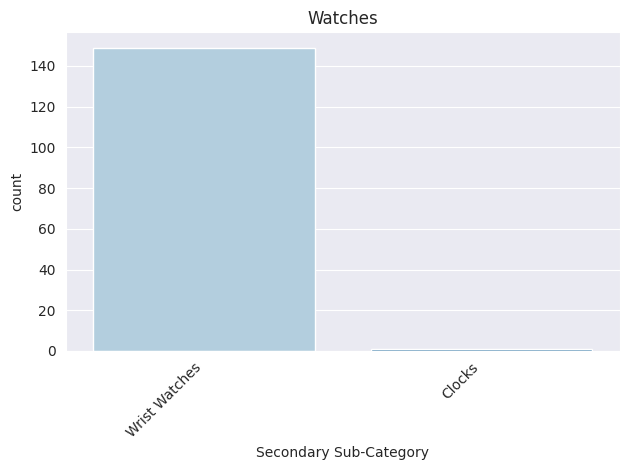

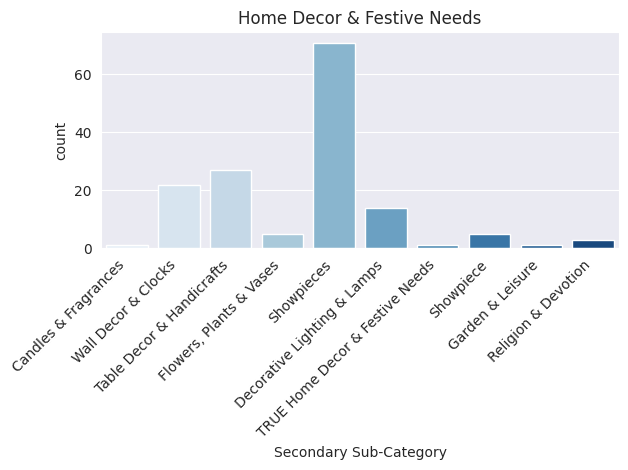

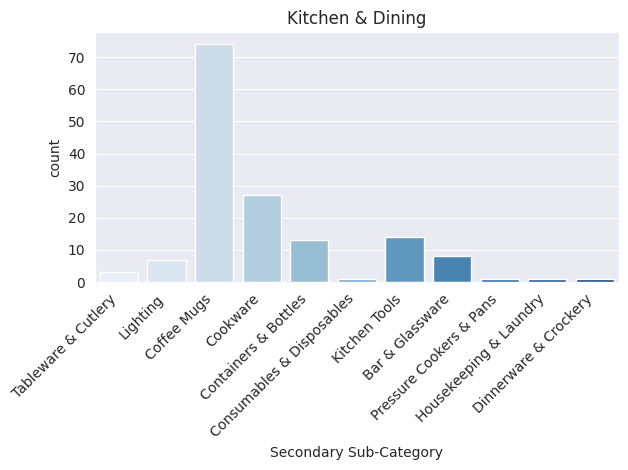

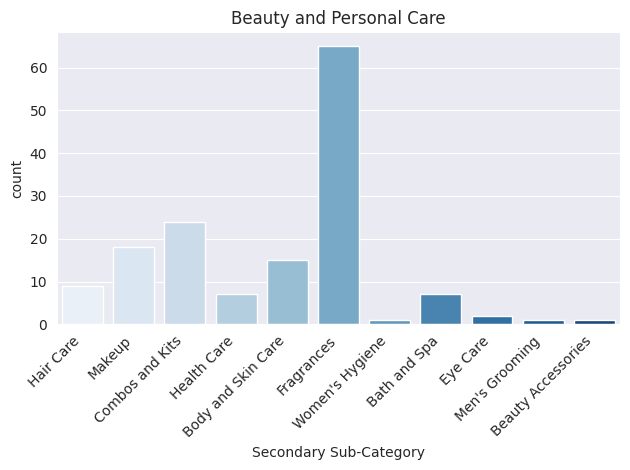

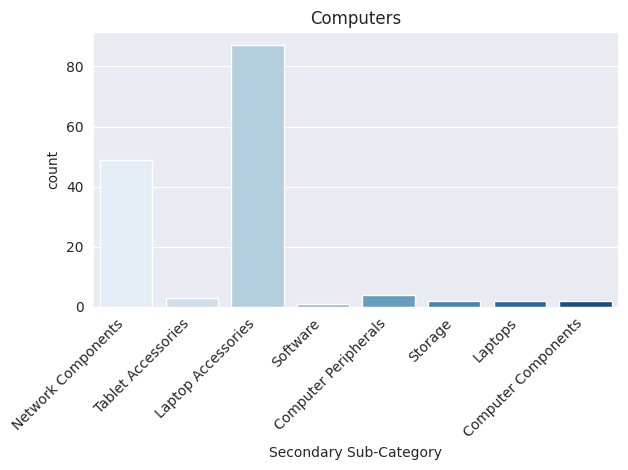

In [8]:
sns.set_style("darkgrid")

for subcateg_1 in flipkart_w_subcat_df["subcateg_1"].unique().tolist():
    sns.countplot(
        x="subcateg_2",
        data=flipkart_w_subcat_df.loc[flipkart_w_subcat_df["subcateg_1"] == subcateg_1],
        palette="Blues",
    )
    plt.title(subcateg_1)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Secondary Sub-Category")
    plt.tight_layout()
    plt.show()


## Affichage des profondeurs de l'arborescence des catégories

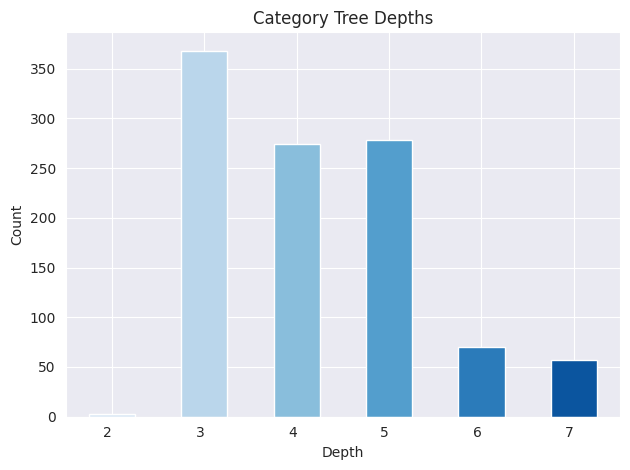

In [9]:
pd.Series(
    [len(x) for x in flipkart_w_subcat_df["product_category_tree"].to_list()]
).value_counts().sort_index().plot.bar(color=sns.color_palette("Blues").as_hex())
plt.title("Category Tree Depths")
plt.xticks(rotation=0, ha="right")
plt.xlabel("Depth")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Impression de toutes les clés pour les spécifications des produits

In [10]:
print(
    sorted(
        set(
            list(
                np.concatenate(
                    [
                        list(x.keys())
                        for x in flipkart_w_subcat_df[
                            "product_specifications"
                        ].to_list()
                    ]
                ).flat
            )
        )
    )
)


['3D Support', 'Acid Free', 'Age Group', 'Airtight', 'Alarm', 'Alarm Clock', 'Alteration Required', 'Altimeter', 'Ammonia Free', 'Antennae', 'Antennae Capacity', 'Application Area', 'Application Frequency', 'Applied For', 'Architecture', 'Area of Use', 'Artist Name', 'Aspect Ratio', 'Assembly Required', 'Audio Input/Output', 'Audio Type', 'Auto Shut Off', 'Back Hieght', 'Backing', 'Backing Material', 'Backlight', 'Bacteria Resistant', 'Bandwidth', 'Barometer', 'Base Features', 'Base Frequency', 'Base Material', 'Base Thickness', 'Batteries Required', 'Battery Cell', 'Battery Life', 'Battery Type', 'Bed Size', 'Bed Type', 'Belt Included', 'Belt Loops', 'Black & White Poster', 'Blade Material', 'Bluetooth', 'Body Fat Percentage', 'Body Material', 'Body Weight', 'Bolster Cover Length', 'Bonsai', 'Bootie', 'Border', 'Bowl Type', 'Box Material', 'Brand', 'Brand Color', 'Brand Fit', 'Break Resistant', 'Brightness', 'Bristle Type', 'Broiler Safe', 'Brush Application', 'Brush Material', 'Brush

## Suppression des informations de catégorie des spécifications des produits

In [11]:
def remove_prod_spec_categ(row):
    if "Category" in row["product_specifications"].keys():
        del row["product_specifications"]["Category"]

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(remove_prod_spec_categ, axis=1)


## Ajout de la chaîne de spécification des produits

In [12]:
def add_prod_spec_str(row):
    if len(row["product_specifications"].items()) > 0:
        # row["product_specifications_str"] = " ".join(
        #     [" ".join(x) for x in list(row["product_specifications"].items())]
        # )
        row["product_specifications_str"] = " ".join(
            list(row["product_specifications"].values())
        )
    else:
        row["product_specifications_str"] = ""

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(add_prod_spec_str, axis=1)

flipkart_w_subcat_df.head(1)


,product_name,product_category_tree,image,description,product_specifications,subcateg_1,subcateg_2,subcateg_3,subcateg_4,subcateg_5,subcateg_6,subcateg_7,product_specifications_str
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"{'Brand': 'Elegance', 'Designed For': 'Door', ...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do,NaN,NaN,NaN,Elegance Door Eyelet Abstract Polyester Door C...


## Conversion de chaînes en minuscules

In [13]:
preproc_feats = ["product_name", "description", "product_specifications_str"]


def to_lower(row):
    for preproc_feat in preproc_feats:
        row[preproc_feat] = row[preproc_feat].lower()

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(to_lower, axis=1)

flipkart_w_subcat_df.head(1)


,product_name,product_category_tree,image,description,product_specifications,subcateg_1,subcateg_2,subcateg_3,subcateg_4,subcateg_5,subcateg_6,subcateg_7,product_specifications_str
0,elegance polyester multicolor abstract eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,key features of elegance polyester multicolor ...,"{'Brand': 'Elegance', 'Designed For': 'Door', ...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do,NaN,NaN,NaN,elegance door eyelet abstract polyester door c...


## Tokénisation

In [14]:
tokenized_feats = [x + "_tokens" for x in preproc_feats]

nltk.download("punkt")


def add_tokens(row):
    for preproc_feat in preproc_feats:
        row[preproc_feat + "_tokens"] = nltk.tokenize.word_tokenize(row[preproc_feat])

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(add_tokens, axis=1)

flipkart_w_subcat_df.head(1)


[nltk_data] Downloading package punkt to /home/gabriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,product_name,product_category_tree,image,description,product_specifications,subcateg_1,subcateg_2,subcateg_3,subcateg_4,subcateg_5,subcateg_6,subcateg_7,product_specifications_str,product_name_tokens,description_tokens,product_specifications_str_tokens
0,elegance polyester multicolor abstract eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,key features of elegance polyester multicolor ...,"{'Brand': 'Elegance', 'Designed For': 'Door', ...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do,NaN,NaN,NaN,elegance door eyelet abstract polyester door c...,"[elegance, polyester, multicolor, abstract, ey...","[key, features, of, elegance, polyester, multi...","[elegance, door, eyelet, abstract, polyester, ..."


## Suppression des mots vides et de la ponctuation

In [15]:
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words("english")
punctuation = list(punctuation)


def del_stpwrd_pnct(row):
    for tokenized_feat in tokenized_feats:
        row[tokenized_feat] = [
            x
            for x in row[tokenized_feat]
            if x not in stopwords and x not in punctuation
        ]

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(del_stpwrd_pnct, axis=1)

flipkart_w_subcat_df.head(1)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,product_name,product_category_tree,image,description,product_specifications,subcateg_1,subcateg_2,subcateg_3,subcateg_4,subcateg_5,subcateg_6,subcateg_7,product_specifications_str,product_name_tokens,description_tokens,product_specifications_str_tokens
0,elegance polyester multicolor abstract eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,key features of elegance polyester multicolor ...,"{'Brand': 'Elegance', 'Designed For': 'Door', ...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do,NaN,NaN,NaN,elegance door eyelet abstract polyester door c...,"[elegance, polyester, multicolor, abstract, ey...","[key, features, elegance, polyester, multicolo...","[elegance, door, eyelet, abstract, polyester, ..."


## Lemmatisation

In [16]:
nltk.download("wordnet")

lemmatizer = nltk.stem.WordNetLemmatizer()


def lemmatize(row):
    for tokenized_feat in tokenized_feats:
        row[tokenized_feat] = [lemmatizer.lemmatize(x) for x in row[tokenized_feat]]

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(lemmatize, axis=1)

flipkart_w_subcat_df.head(1)


[nltk_data] Downloading package wordnet to /home/gabriel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,product_name,product_category_tree,image,description,product_specifications,subcateg_1,subcateg_2,subcateg_3,subcateg_4,subcateg_5,subcateg_6,subcateg_7,product_specifications_str,product_name_tokens,description_tokens,product_specifications_str_tokens
0,elegance polyester multicolor abstract eyelet ...,"[Home Furnishing, Curtains & Accessories, Curt...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,key features of elegance polyester multicolor ...,"{'Brand': 'Elegance', 'Designed For': 'Door', ...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do,NaN,NaN,NaN,elegance door eyelet abstract polyester door c...,"[elegance, polyester, multicolor, abstract, ey...","[key, feature, elegance, polyester, multicolor...","[elegance, door, eyelet, abstract, polyester, ..."


## Suppression de tokens sans au moins deux caractères alphabétiques
noise removal

In [17]:
# multi_alpha_patrn = re.compile(r".*?[A-Za-z]{2}.*")
# # remove all numerals

# def keep_multi_alpha(row):
#     for tokenized_feat in tokenized_feats:
#         row[tokenized_feat] = [
#             x for x in row[tokenized_feat] if re.match(multi_alpha_patrn, x)
#         ]

#     return row


# flipkart_w_subcat_df = flipkart_w_subcat_df.apply(keep_multi_alpha, axis=1)


## Mots les plus fréquents par catégorie et caractéristique

In [18]:
def word_stats_by_categ_feat(num_top_words=10):
    for main_categ in flipkart_w_subcat_df["subcateg_1"].unique():
        categ_df = flipkart_w_subcat_df.loc[
            flipkart_w_subcat_df["subcateg_1"] == main_categ
        ]
        previous_combined = []

        print(f"Primary category: {main_categ}")

        for tokenized_feat in tokenized_feats:
            top_words_list = (
                pd.Series(list(np.concatenate(categ_df[tokenized_feat].to_list()).flat))
                .value_counts()
                .nlargest(n=num_top_words)
                .index.to_list()
            )

            print(
                f"\t{num_top_words} top words in {tokenized_feat}:\n\t\t{top_words_list}"
            )

            all_words_list = (
                pd.Series(list(np.concatenate(categ_df[tokenized_feat].to_list()).flat))
                .unique()
                .tolist()
            )

            print(f"\tAll words in {tokenized_feat}:\n\t{all_words_list}")

            previous_combined += all_words_list

            previous_combined = list(set(previous_combined))

            print(f"\tNumber of words in {tokenized_feat}: {len(all_words_list)}")
            print(
                f"\tNumber of words in previous features combined: {len(previous_combined)}"
            )


word_stats_by_categ_feat()


Primary category: Home Furnishing
	10 top words in product_name_tokens:
		['cotton', 'single', 'abstract', 'double', 'floral', 'cover', 'quilt', 'blanket', 'comforter', 'polyester']
	All words in product_name_tokens:
	['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'santosh', 'royal', 'fashion', 'cotton', 'printed', 'king', 'sized', 'double', 'bedsheet', 'jaipur', 'print', 'floral', 'embroidered', 'diwan', 'set', 'house', 'queen', 'duvet', 'cover', 'riva', 'carpet', 'free', 'bath', 'mat', 'classic', 'loop', 'shag', 'bathmat_ri-527', 'jmd', 'cushion', 'kripa', "'s", 'prime', '4', 'seater', 'table', '8', 'craft', 'trade', 'oval', 'wood', 'coaster', 'rama', 'single', 'quilt', 'comforter', 'pink-red', 'yellow', 'shop', 'rajasthan', 'dohar', 'artisan', 'creation', 'checkered', 'brown', 'blue-beige', 'remtex', 'export', 'cartoon', 'india', 'bhavya', 'velvet', 'sofa', 'dreamshomes', 'jewelkraft', 'design', 'pink', 'linen', 'tidy', 'jbc', 'collection', 'lushome

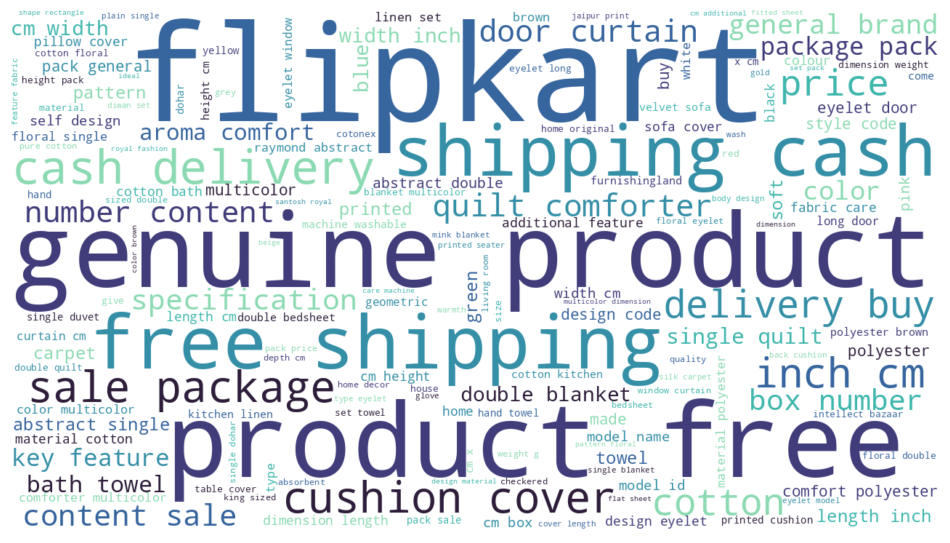

In [19]:
home_furnishing_df = flipkart_w_subcat_df.loc[
    flipkart_w_subcat_df["subcateg_1"] == "Home Furnishing"
]
home_furnishing_words = " ".join(
    list(np.concatenate(home_furnishing_df["product_name_tokens"].to_list()).flat)
    + list(np.concatenate(home_furnishing_df["description_tokens"].to_list()).flat)
)
wordcloud = WordCloud(
    width=1280,
    height=720,
    background_color="white",
    min_font_size=10,
    colormap=ListedColormap(sns.color_palette("mako")),
).generate(home_furnishing_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [20]:
noise_patrn = re.compile(r".*?\w\.\w.*|.*?\d+.*|^'.*|^-.*|^.$|.*?/.*")


def remove_noise(row):
    for tokenized_feat in tokenized_feats:
        row[tokenized_feat] = [
            x for x in row[tokenized_feat] if not re.match(noise_patrn, x)
        ]

    return row


flipkart_w_subcat_wo_noise_df = flipkart_w_subcat_df.apply(remove_noise, axis=1)


In [21]:
inter_categ_thresh = 2
intra_categ_thresh = 0.02

word_counts_by_categ = {}
words_to_remove_by_inter_categ = {}
words_to_remove_by_intra_categ = {}
entries_per_categ = {}
main_categ_list = flipkart_w_subcat_wo_noise_df["subcateg_1"].unique()
known_irrel_words = [
    "buy",
    "genuine",
    "product",
    "day",
    "replacement",
    "guarantee",
    "free",
    "shipping",
    "cash",
    "delivery",
]

for main_categ in main_categ_list:
    categ_df = flipkart_w_subcat_wo_noise_df.loc[
        flipkart_w_subcat_wo_noise_df["subcateg_1"] == main_categ
    ]
    word_counts_by_categ[main_categ] = (
        pd.Series(
            list(np.concatenate(categ_df["product_name_tokens"].to_list()).flat)
            + list(np.concatenate(categ_df["description_tokens"].to_list()).flat)
        )
        .value_counts()
        .to_dict()
    )
    entries_per_categ[main_categ] = categ_df.shape[0]
    words_to_remove_by_inter_categ[main_categ] = []
    words_to_remove_by_intra_categ[main_categ] = []

for main_categ in main_categ_list:
    other_categs_list = [x for x in main_categ_list if x != main_categ]
    intra_categ_thresh_num = entries_per_categ[main_categ] * intra_categ_thresh

    for word in word_counts_by_categ[main_categ].keys():
        other_categs_found_in = 0

        for other_categ in other_categs_list:
            if word in word_counts_by_categ[other_categ].keys():
                other_categs_found_in += 1

        if other_categs_found_in > inter_categ_thresh:
            words_to_remove_by_inter_categ[main_categ] += [word]

        if word_counts_by_categ[main_categ][word] < intra_categ_thresh_num:
            words_to_remove_by_intra_categ[main_categ] += [word]


def remove_irrel_words(row, inter_categ_words_list, intra_categ_words_list):
    orig_product_name_tokens = row["product_name_tokens"].copy()
    orig_description_tokens = row["description_tokens"].copy()
    row["product_name_tokens"] = [
        x
        for x in row["product_name_tokens"]
        if x not in inter_categ_words_list + intra_categ_words_list
    ]
    row["description_tokens"] = [
        x
        for x in row["description_tokens"]
        if x not in inter_categ_words_list + intra_categ_words_list
    ]

    if len(row["product_name_tokens"]) == 0:
        row["product_name_tokens"] = [
            x for x in orig_product_name_tokens if x not in inter_categ_words_list
        ]

    if len(row["description_tokens"]) == 0:
        row["description_tokens"] = [
            x for x in orig_description_tokens if x not in inter_categ_words_list
        ]

    if len(row["product_name_tokens"]) == 0:
        row["product_name_tokens"] = [
            x for x in orig_product_name_tokens if x not in known_irrel_words
        ]

    if len(row["description_tokens"]) == 0:
        row["description_tokens"] = [
            x for x in orig_description_tokens if x not in known_irrel_words
        ]

    return row


flipkart_no_irrel_df = flipkart_w_subcat_wo_noise_df.copy()

for main_categ in main_categ_list:
    flipkart_no_irrel_df.loc[
        flipkart_no_irrel_df["subcateg_1"] == main_categ
    ] = flipkart_no_irrel_df.loc[
        flipkart_no_irrel_df["subcateg_1"] == main_categ
    ].apply(
        remove_irrel_words,
        args=[
            words_to_remove_by_inter_categ[main_categ],
            words_to_remove_by_intra_categ[main_categ],
        ],
        axis=1,
    )


In [22]:
def remove_repeats(row):
    tokens_feats = ["product_name_tokens", "description_tokens"]

    for tokens_feat in tokens_feats:
        repeats_removed = []
        last_token = ""

        for token in row[tokens_feat]:
            if token != last_token:
                repeats_removed += [token]

            last_token = token

        row[tokens_feat] = repeats_removed

    return row


flipkart_no_irrel_df = flipkart_no_irrel_df.apply(remove_repeats, axis=1)


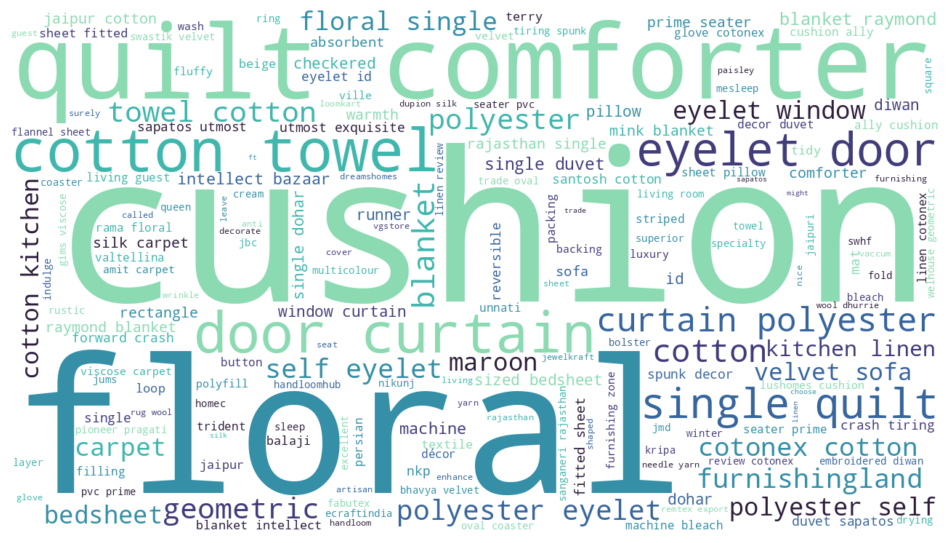

In [23]:
home_furnishing_df = flipkart_no_irrel_df.loc[
    flipkart_no_irrel_df["subcateg_1"] == "Home Furnishing"
]
home_furnishing_words = " ".join(
    list(np.concatenate(home_furnishing_df["product_name_tokens"].to_list()).flat)
    + list(np.concatenate(home_furnishing_df["description_tokens"].to_list()).flat)
)
wordcloud = WordCloud(
    width=1280,
    height=720,
    background_color="white",
    min_font_size=10,
    colormap=ListedColormap(sns.color_palette("mako")),
).generate(home_furnishing_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:
def insert_cleaned_strings(row):
    row["product_name"] = " ".join(row["product_name_tokens"])
    row["description"] = " ".join(row["description_tokens"])

    return row

flipkart_clean_df = flipkart_no_irrel_df.apply(insert_cleaned_strings, axis=1)

flipkart_clean_df.head(1)

,product_name,product_category_tree,image,description,product_specifications,subcateg_1,subcateg_2,subcateg_3,subcateg_4,subcateg_5,subcateg_6,subcateg_7,product_specifications_str,product_name_tokens,description_tokens,product_specifications_str_tokens
0,polyester eyelet door curtain,"[Home Furnishing, Curtains & Accessories, Curt...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,polyester eyelet door curtain floral curtain p...,"{'Brand': 'Elegance', 'Designed For': 'Door', ...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do,NaN,NaN,NaN,elegance door eyelet abstract polyester door c...,"[polyester, eyelet, door, curtain]","[polyester, eyelet, door, curtain, floral, cur...","[elegance, door, eyelet, abstract, polyester, ..."


In [25]:
def generate_bigrams(row):
    desc_bigrams = []

    for i in range(len(row["description_tokens"]) - 1):
        desc_bigrams += [
            f"{row['description_tokens'][i]} {row['description_tokens'][i + 1]}"
        ]

    row["description_bigrams"] = desc_bigrams

    return row


flipkart_w_bigram_df = flipkart_clean_df.apply(generate_bigrams, axis=1)

flipkart_w_bigram_df.head(1)


,product_name,product_category_tree,image,description,product_specifications,subcateg_1,subcateg_2,subcateg_3,subcateg_4,subcateg_5,subcateg_6,subcateg_7,product_specifications_str,product_name_tokens,description_tokens,product_specifications_str_tokens,description_bigrams
0,polyester eyelet door curtain,"[Home Furnishing, Curtains & Accessories, Curt...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,polyester eyelet door curtain floral curtain p...,"{'Brand': 'Elegance', 'Designed For': 'Door', ...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet Do,NaN,NaN,NaN,elegance door eyelet abstract polyester door c...,"[polyester, eyelet, door, curtain]","[polyester, eyelet, door, curtain, floral, cur...","[elegance, door, eyelet, abstract, polyester, ...","[polyester eyelet, eyelet door, door curtain, ..."


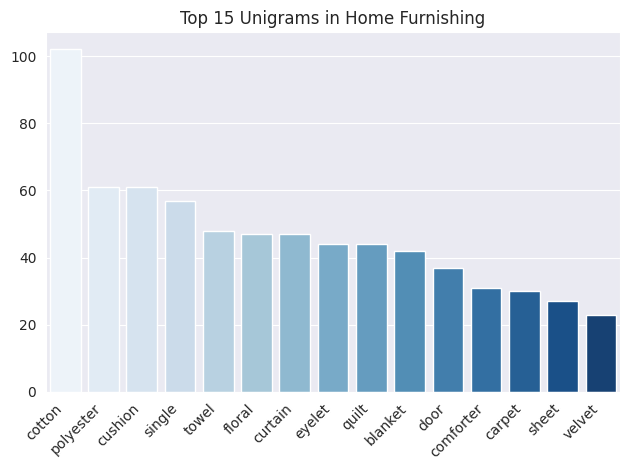

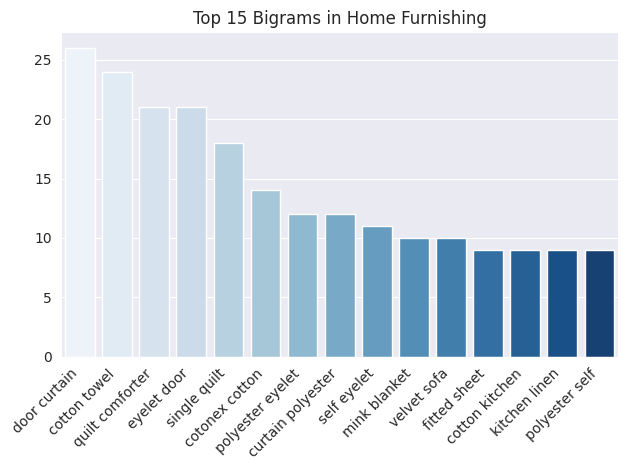

In [26]:
home_furnishing_df = flipkart_w_bigram_df.loc[
    flipkart_w_bigram_df["subcateg_1"] == "Home Furnishing"
]
num_ngrams = 15

for feat in [["description_tokens", "Unigrams"], ["description_bigrams", "Bigrams"]]:
    top_ngram_list = (
        pd.Series(list(np.concatenate(home_furnishing_df[feat[0]].to_list()).flat))
        .value_counts()
        .nlargest(n=num_ngrams)
    )

    sns.barplot(x=top_ngram_list.index, y=top_ngram_list.values, palette="Blues")
    plt.title(f"Top {num_ngrams} {feat[1]} in Home Furnishing")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [79]:
# flipkart_swc_kmeans_df = flipkart_w_bigram_df[["product_name", "subcateg_1"]].copy()
flipkart_swc_kmeans_df = flipkart_w_bigram_df[["description", "subcateg_1"]].copy()
cnt_vect = CountVectorizer()
# matrix = cnt_vect.fit_transform(flipkart_swc_kmeans_df["product_name"].to_list())
matrix = cnt_vect.fit_transform(flipkart_swc_kmeans_df["description"].to_list())
swc_feats = cnt_vect.get_feature_names_out()
flipkart_swc_kmeans_df = pd.concat(
    [flipkart_swc_kmeans_df, pd.DataFrame(matrix.toarray(), columns=swc_feats)], axis=1
)
flipkart_swc_kmeans_df["kmeans_group"] = (
    KMeans(
        n_clusters=len(flipkart_swc_kmeans_df["subcateg_1"].unique().tolist()),
        n_init=10,
        random_state=0,
    )
    .fit(MinMaxScaler().fit_transform(flipkart_swc_kmeans_df[swc_feats]))
    # .fit(matrix)
    .labels_
)

for main_categ in flipkart_swc_kmeans_df["subcateg_1"].unique().tolist():
    categ_label = (
        flipkart_swc_kmeans_df.loc[flipkart_swc_kmeans_df["subcateg_1"] == main_categ][
            "kmeans_group"
        ]
        .value_counts()
        .idxmax()
    )
    
    print(f"{main_categ}: {categ_label}")


Home Furnishing: 0
Baby Care: 0
Watches: 4
Home Decor & Festive Needs: 0
Kitchen & Dining: 0
Beauty and Personal Care: 0
Computers: 0


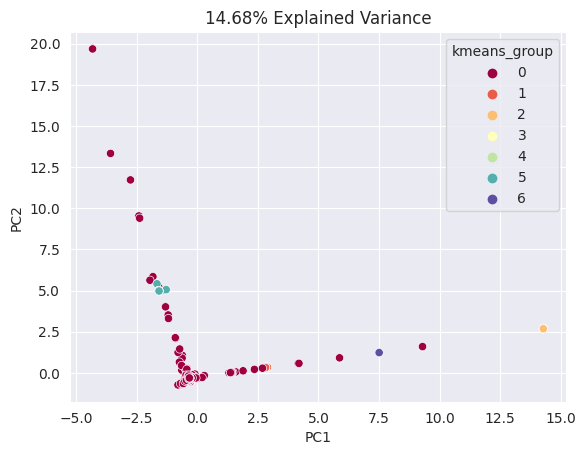

In [80]:
pca_kmeans = PCA(n_components=2)
kmeans_pca_df = pd.concat(
    [
        pd.DataFrame(
            pca_kmeans.fit_transform(flipkart_swc_kmeans_df[swc_feats]),
            columns=["PC1", "PC2"],
        ),
        flipkart_swc_kmeans_df[["kmeans_group"]],
    ],
    axis=1,
)
exp_var_str = f"{round(sum(pca_kmeans.explained_variance_ratio_.tolist()) * 100, 2)}% Explained Variance"
pca_scatter = sns.scatterplot(
    kmeans_pca_df, x="PC1", y="PC2", hue="kmeans_group", palette="Spectral"
)

plt.title(exp_var_str)
plt.show()
